### To connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Zip Extractor

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Datasets/2_intel/images/intel/inference_set_resize.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/Datasets/2_intel/images/intel')
zip_ref.close()

In [ ]:
import glob
len(glob.glob('/content/drive/MyDrive/Datasets/2_intel/images/intel/inference_set_resize/*/*'))

3000

In [ ]:
import glob
len(glob.glob("/content/drive/MyDrive/Datasets/2_intel/images/intel/seg_train/*/*"))

14034

In [ ]:
import glob
len(glob.glob("/content/drive/MyDrive/Datasets/2_intel/images/intel/seg_pred/*"))

7301

### Train Test Folder Path

#### Small train test val

1.   List item
2.   List item



In [ ]:
train_dir = '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/train'
tesr_dir = '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/seg_test'
val_dir = '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/val'

#### Original Big Dataset

In [ ]:
train_dir = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_train'
test_dir = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_test'
pred_dir = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred'

### Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten, Dropout, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16

## Transfer Learning Models

### VGG16

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:

from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

In [ ]:
# conv_base.trainable = False

In [ ]:

# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = val_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

Found 9820 files belonging to 6 classes.
Found 4214 files belonging to 6 classes.


In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    directory = test_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)


Found 3000 files belonging to 6 classes.


In [ ]:
test_ds = test_ds.map(process)

In [ ]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint
filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_ds,epochs=40,validation_data=validation_ds,callbacks=callbacks_list)

Epoch 1/40
307/307 [==============================] - ETA: 0s - loss: 0.7248 - accuracy: 0.7640
Epoch 1: val_accuracy improved from -inf to 0.77800, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/weights-improvement-01-0.78.hdf5
307/307 [==============================] - 1549s 5s/step - loss: 0.7248 - accuracy: 0.7640 - val_loss: 0.8098 - val_accuracy: 0.7780
Epoch 2/40
307/307 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.8470
Epoch 2: val_accuracy improved from 0.77800 to 0.81733, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/weights-improvement-02-0.82.hdf5
307/307 [==============================] - 38s 121ms/step - loss: 0.4532 - accuracy: 0.8470 - val_loss: 0.6092 - val_accuracy: 0.8173
Epoch 3/40
307/307 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.8816
Epoch 3: val_accuracy improved from 0.81733 to 0.85067, saving model to /content/drive/MyDrive/Datasets/2_intel/best_t

In [ ]:
print("Evaluate on test data")
results = model.evaluate(pred_ds, batch_size=20)
print("test loss, test acc:", results)

Evaluate on test data
132/132 [==============================] - 478s 3s/step - loss: 0.6448 - accuracy: 0.9003
test loss, test acc: [0.6448062062263489, 0.9003322124481201]


In [ ]:
model.save('/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/vgg16_1024_512_b5_to_all_train_20e.h5')

In [ ]:
from keras.models import load_model

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Datasets/2_intel/best_trained_models/vgg16_1024_512_b5_to_all_train_40e_91.h5')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              8389632   
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                      

In [ ]:
import glob
import os 
img = glob.glob(os.path.join('/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred','3.jpg'))

In [ ]:
print(img)

['/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred/3.jpg']


In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
import cv2

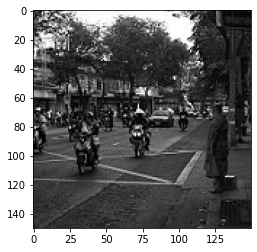

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
img=cv2.imread('/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred/3.jpg')
#Displaying image using plt.imshow() method
plt.imshow(img)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
image = cv2.imread('/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred/3.jpg')
# img = cv2.resize(image, (224, 224))
# img.shape

In [ ]:
image.shape

(150, 150, 3)

In [ ]:
img = np.expand_dims(img, axis=0)
img.shape

(1, 150, 150, 3)

In [ ]:
import os 
os.listdir('/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_train')

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
predict_x=model.predict(img)
predict_x

1/1 [==============================] - 8s 8s/step


array([[0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
classes_x=np.argmax(predict_x,axis=1)
classes_x[0]

5

In [ ]:
dest_path = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class'
src_path = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred'

In [ ]:
def create_folder_at_destination(dest_path,folder_name_list):
    for folder_name in folder_name_list:
        os.mkdir(os.path.join(dest_path,folder_name))
    dest_folder_paths = glob.glob(os.path.join(dest_path,'*'))
    return dest_folder_paths


In [ ]:
dest_folders = create_folder_at_destination(dest_path,os.listdir('/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_train'))

In [ ]:
dest_folders

['/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/buildings',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/forest',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/glacier',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/mountain',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/sea',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/street']

In [ ]:
# os.listdir('path')

In [ ]:
# source_folder_path = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_test'
# dest_folder_path = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class'
# create_folder_at_destination(dest_folder_path,folder_names(source_folder_path))

['/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/buildings',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/forest',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/glacier',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/mountain',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/sea',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/street']

In [ ]:
# source_folder_path = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred'
# dest_folder_path = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class'

In [ ]:
img_list = glob.glob(os.path.join('/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred','*.jpg'))

In [ ]:
len(img_list)

5801

In [ ]:
img_list1 = glob.glob(os.path.join('/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/*/','*.jpg'))
len(img_list1)

1088

In [ ]:
5801+1088

6889

In [ ]:
import glob
import shutil
import os
import random

In [ ]:
dest_folders = glob.glob('/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/*')

In [ ]:
dest_folders

['/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/buildings',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/forest',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/glacier',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/mountain',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/sea',
 '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred_class/street']

In [ ]:
for img_path in img_list:
  image = cv2.imread(img_path)
  # img = cv2.resize(image, (224, 224))
  img = np.expand_dims(image, axis=0)
  predict_x=model.predict(img)
  classes_x=np.argmax(predict_x,axis=1)
  if classes_x[0] == 0:
    shutil.move(img_path, dest_folders[0])
    print(classes_x[0])
  elif classes_x[0] == 1:
    shutil.move(img_path, dest_folders[1])
    print(classes_x[0])
  elif classes_x[0] == 2:
    shutil.move(img_path, dest_folders[2])
    print(classes_x[0])
  elif classes_x[0] == 3:
    shutil.move(img_path, dest_folders[3])
    print(classes_x[0])
  elif classes_x[0] == 4:
    shutil.move(img_path, dest_folders[4])
    print(classes_x[0])
  elif classes_x[0] == 5:
    shutil.move(img_path, dest_folders[5])
    print(classes_x[0])
  else :
    print(img_path + ' not found dest location')

print('Mission Complete')


  

1/1 [==============================] - 0s 16ms/step
3
1/1 [==============================] - 0s 16ms/step
4
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 16ms/step
4
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 17ms/step
4
1/1 [==============================] - 0s 17ms/step
3
1/1 [==============================] - 0s 16ms/step
4
1/1 [==============================] - 0s 17ms/step
4
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 18ms/step
2
1/1 [==============================] - 0s 19ms/step
4
1/1 [==============================] - 0s 24ms/step
5
1/1 [=======================

KeyboardInterrupt: ignored

## EfficientNetV2S using Transfer learning

In [ ]:
tf.keras.applications.EfficientNetV2S

In [ ]:
conv_base = tf.keras.applications.EfficientNetV2S(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

82420632/82420632 [==============================] - 2s 0us/step


In [ ]:
conv_base.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_3[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 75, 75, 24)   96          ['stem_conv[0][0]'

In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'top_conv':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_3 False
rescaling False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block1a_add False
block1b_project_conv False
block1b_project_bn False
block1b_project_activation False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block2c_expand_conv False
block2c_expand_bn False
block2c_expand_activation False
block2c_project_conv False
block2c_project_bn False
block2c_drop False
block2c_add False
block2d_expand_conv False
block2d_expand_bn False
block2d_expand_activation False
block2d_project_conv False
block2d_project_bn False
block2d_drop False
block2d_add False
block3a_expand_conv False
block3a_expand_bn Fa

In [ ]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(6,activation='softmax'))

In [ ]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = test_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint
filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/b0_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hd5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_ds,epochs=20,validation_data=validation_ds,callbacks=callbacks_list)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


439/439 [==============================] - ETA: 0s - loss: 1.5604 - accuracy: 0.4567
Epoch 1: val_accuracy improved from -inf to 0.52433, saving model to weights-improvement-01-0.52.hdf5
439/439 [==============================] - 64s 115ms/step - loss: 1.5604 - accuracy: 0.4567 - val_loss: 1.3863 - val_accuracy: 0.5243
Epoch 2/20
439/439 [==============================] - ETA: 0s - loss: 1.1459 - accuracy: 0.5739
Epoch 2: val_accuracy improved from 0.52433 to 0.57967, saving model to weights-improvement-02-0.58.hdf5
439/439 [==============================] - 54s 121ms/step - loss: 1.1459 - accuracy: 0.5739 - val_loss: 1.1656 - val_accuracy: 0.5797
Epoch 3/20
439/439 [==============================] - ETA: 0s - loss: 1.0119 - accuracy: 0.6176
Epoch 3: val_accuracy improved from 0.57967 to 0.61067, saving model to weights-improvement-03-0.61.hdf5
439/439 [==============================] - 49s 111ms/step - loss: 1.0119 - accuracy: 0.6176 - val_loss: 0.9923 - val_accuracy: 0.6107
Epoch 4/2

In [ ]:
model.save('/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/env2s_1024_512_top_conv_to_all_train_20e.h5')

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import albumentations as albu
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import efficientnet.keras as efn

ModuleNotFoundError: ignored

In [ ]:
efnb0 = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(150,150,3))

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_8 (Dropout)         (None, 2560)              0         
                                                                 
 dense_12 (Dense)            (None, 6)                 15366     
                                                                 
Total params: 64,113,053
Trainable params: 63,802,326
Non-trainable params: 310,727
_________________________________________________________________


In [ ]:
optimizer = Adam(lr=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#  = model.fit(train_data_generator, validation_data = valid_data_generator, callbacks = [early_stop, rlrop],verbose = 1, epochs = epochs)
model_history = model.fit(train_ds,epochs=20,validation_data=validation_ds,callbacks=[callbacks_list,rlrop])
#saving the trained model weights as data file in .h5 format
model.save_weights("efficientnetb0_weights.h5")

Epoch 1/20


ValueError: ignored

In [ ]:
import glob
len(glob.glob('/content/drive/MyDrive/Datasets/2_intel/images/intel/train_val/*/*/*.jpg'))

0

In [ ]:
len(glob.glob('/content/drive/MyDrive/Datasets/2_intel/images/intel/output/*/*/*.jpg'))


14034

In [ ]:
len(glob.glob('/content/drive/MyDrive/Datasets/2_intel/images/intel/seg_test/*/*.jpg'))


3000

## tf.keras.applications.EfficientNetB2

In [ ]:
conv_base = tf.keras.applications.EfficientNetB2(
    weights='imagenet',
    include_top = False,
    input_shape=(260,260,3)
)

31790344/31790344 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 260, 260, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 260, 260, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 260, 260, 3)  0           ['normalization[0][0

In [ ]:
for a,b in enumerate(conv_base.layers):
  print(a.name,b)

In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'top_conv':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
rescaling False
normalization False
tf.math.truediv False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
b

In [ ]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
model = Sequential()

model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))

In [ ]:
train_dir = '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/train'
test_dir = '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/seg_test'
val_dir = '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/val'

In [ ]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(260,260)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = val_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(260,260)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = test_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(260,260)
)



# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
test_ds = test_ds.map(process)

Found 9820 files belonging to 6 classes.
Found 4214 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])


from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint
filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/ENB2_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_ds,epochs=40,validation_data=validation_ds,callbacks=callbacks_list)


Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


307/307 [==============================] - ETA: 0s - loss: 1.7567 - accuracy: 0.2234 
Epoch 1: val_accuracy improved from -inf to 0.27646, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/ENB2_weights-improvement-01-0.28.h5
307/307 [==============================] - 4855s 15s/step - loss: 1.7567 - accuracy: 0.2234 - val_loss: 1.6720 - val_accuracy: 0.2765
Epoch 2/40
307/307 [==============================] - ETA: 0s - loss: 1.6761 - accuracy: 0.2616
Epoch 2: val_accuracy did not improve from 0.27646
307/307 [==============================] - 60s 195ms/step - loss: 1.6761 - accuracy: 0.2616 - val_loss: 1.6640 - val_accuracy: 0.2470
Epoch 3/40
307/307 [==============================] - ETA: 0s - loss: 1.6514 - accuracy: 0.2809
Epoch 3: val_accuracy did not improve from 0.27646
307/307 [==============================] - 60s 195ms/step - loss: 1.6514 - accuracy: 0.2809 - val_loss: 1.7262 - val_accuracy: 0.2375
Epoch 4/40
307/307 [==============================] -

In [ ]:
history = model.fit(train_ds,epochs=110,validation_data=validation_ds,callbacks=callbacks_list)


Epoch 1/110
307/307 [==============================] - ETA: 0s - loss: 1.4040 - accuracy: 0.4115
Epoch 1: val_accuracy did not improve from 0.47556
307/307 [==============================] - 65s 210ms/step - loss: 1.4040 - accuracy: 0.4115 - val_loss: 1.2894 - val_accuracy: 0.4561
Epoch 2/110
307/307 [==============================] - ETA: 0s - loss: 1.4037 - accuracy: 0.4044
Epoch 2: val_accuracy improved from 0.47556 to 0.49478, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/ENB2_weights-improvement-02-0.49.h5
307/307 [==============================] - 60s 194ms/step - loss: 1.4037 - accuracy: 0.4044 - val_loss: 1.2774 - val_accuracy: 0.4948
Epoch 3/110
307/307 [==============================] - ETA: 0s - loss: 1.3888 - accuracy: 0.4180
Epoch 3: val_accuracy improved from 0.49478 to 0.49905, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/ENB2_weights-improvement-03-0.50.h5
307/307 [==============================] - 60s 193ms/s

## Try with small dataset and find best parameter and then train entire model on that Using VGG16

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten, Dropout, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16

import glob
import numpy as np
import shutil
import os 

In [ ]:
train_dir = '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/train'
tesr_dir = '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/seg_test'
val_dir = '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/val'

In [ ]:
images = glob.glob(os.path.join(train_dir,'*/*'))
images

[]

['/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/train/buildings',
 '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/train/forest',
 '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/train/glacier',
 '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/train/mountain',
 '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/train/sea',
 '/content/drive/MyDrive/Datasets/2_intel/images/train_val_test/train/street']

In [ ]:
train_dir = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_train'
# test_dir = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_test'
pred_dir = '/content/drive/MyDrive/Datasets/2_intel/2_intel_classification_imgs/intel/seg_pred'

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/drive/MyDrive/Datasets/2_intel/images/intel/seg_test", output="/content/drive/MyDrive/Datasets/2_intel/images/from_ori_test_create_train_val",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

# Split val/test with a fixed number of items, e.g. `(100, 100)`, for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
# Set 3 values, e.g. `(300, 100, 100)`, to limit the number of training values.
# splitfolders.fixed("input_folder", output="output",
#     seed=1337, fixed=(100, 100), oversample=False, group_prefix=None, move=False) # default values

Copying files: 3000 files [01:07, 44.68 files/s]


In [ ]:
len(glob.glob("/content/drive/MyDrive/Datasets/2_intel/images/from_ori_test_create_train_val/val/*/*"))+len(glob.glob("/content/drive/MyDrive/Datasets/2_intel/images/from_ori_test_create_train_val/train/*/*"))

3000

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(6,activation='softmax'))

In [ ]:
train_dir = '/content/drive/MyDrive/Datasets/2_intel/images/from_ori_test_create_train_val/train'
val_dir = '/content/drive/MyDrive/Datasets/2_intel/images/from_ori_test_create_train_val/val'

In [ ]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = val_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

Found 2398 files belonging to 6 classes.
Found 602 files belonging to 6 classes.


In [ ]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint
filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/vgg16_small_ds_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_ds,epochs=20,validation_data=validation_ds,callbacks=callbacks_list)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


75/75 [==============================] - ETA: 0s - loss: 1.0352 - accuracy: 0.6689
Epoch 1: val_accuracy improved from -inf to 0.18106, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/vgg16_small_ds_weights-improvement-01-0.18.hdf5
75/75 [==============================] - 1004s 12s/step - loss: 1.0352 - accuracy: 0.6689 - val_loss: 12.1291 - val_accuracy: 0.1811
Epoch 2/20
75/75 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.8098
Epoch 2: val_accuracy improved from 0.18106 to 0.72093, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/vgg16_small_ds_weights-improvement-02-0.72.hdf5
75/75 [==============================] - 10s 127ms/step - loss: 0.5786 - accuracy: 0.8098 - val_loss: 1.2161 - val_accuracy: 0.7209
Epoch 3/20
75/75 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.8169
Epoch 3: val_accuracy did not improve from 0.72093
75/75 [===================

In [ ]:
print("Evaluate on test data")
results = model.evaluate(pred_ds, batch_size=20)
print("test loss, test acc:", results)

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier



import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle

# print(tf.VERSION)
print(tf.keras.__version__)

2.9.0


In [ ]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization


In [ ]:
def create_model(init_mode):
    # define model
    model = VGG16(weights='imagenet',include_top = False,input_shape=(150,150,3))

    conv_base.trainable = True

    set_trainable = False

    for layer in conv_base.layers:
      if layer.name == 'block5_conv1':
        set_trainable = True
      if set_trainable:
        layer.trainable = True
      else:
        layer.trainable = False

    for layer in conv_base.layers:
      print(layer.name,layer.trainable)

    model = Sequential()

    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(1024,activation='relu',kernel_initializer=init_mode))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512,activation='relu',kernel_initializer=init_mode))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(6,activation='softmax',kernel_initializer=init_mode))

    # compile model
    # model.compile(loss='categorical_crossentropy',
    #           optimizer=RMSprop(),
    #           metrics=['accuracy'])
    model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

    return model

In [ ]:
for i in range(len(init_mode)):
  temp = init_mode[i]
  print(f'hello this {temp} ')

hello this uniform 
hello this lecun_uniform 
hello this normal 
hello this zero 
hello this glorot_normal 
hello this glorot_uniform 
hello this he_normal 
hello this he_uniform 


In [ ]:
import os

In [ ]:
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
for i in range(len(init_mode)):
  from tensorflow.keras.callbacks import ModelCheckpoint
  # checkpoint
  temp = init_mode[i]
  # os.mkdir(f'/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/{init_mode[i]}')
  # print(f'Now..............{temp}..............................starts')
  if i == 0:
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/0/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 1:
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/1/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 2 :
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/2/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 3 :
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/3/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 4 :
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/4/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 5 :
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/5/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 6 :
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/6/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 7 :
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/7/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"

  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  model = create_model(init_mode[i]) 
  history = model.fit(train_ds,epochs=10,validation_data=validation_ds,callbacks=callbacks_list)


input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9775
Epoch 1: val_accuracy improved from -inf to 0.67442, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/0/vgg16_small_ds__weights-improvement-01-0.67.h5
75/75 [==============================] - 12s 138ms/step - loss: 0.0708 - accuracy: 0.9775 - val_loss: 2.0386 - val_accuracy: 0.6744
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9908
Epoch 2: val_accuracy improved from 0.67442 to 0.87874, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_da

In [ ]:
# So uniform is best kernal initializer for us

### grid search for l1 l2 regularization

In [ ]:
from keras.regularizers import l1

In [ ]:
def create_model(init_mode,l1_value):
    # define model
    model = VGG16(weights='imagenet',include_top = False,input_shape=(150,150,3))

    conv_base.trainable = True

    set_trainable = False

    for layer in conv_base.layers:
      if layer.name == 'block5_conv1':
        set_trainable = True
      if set_trainable:
        layer.trainable = True
      else:
        layer.trainable = False

    for layer in conv_base.layers:
      print(layer.name,layer.trainable)

    model = Sequential()

    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(1024,activation='relu',kernel_initializer=init_mode,bias_regularizer=l1(l1_value)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512,activation='relu',kernel_initializer=init_mode,bias_regularizer=l1(l1_value)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(6,activation='softmax',kernel_initializer=init_mode,bias_regularizer=l1(l1_value)))

    # compile model
    # model.compile(loss='categorical_crossentropy',
    #           optimizer=RMSprop(),
    #           metrics=['accuracy'])
    model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

    return model

In [ ]:
...
# grid search values
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

init_mode = 'uniform'
for i in range(len(values)):
  from tensorflow.keras.callbacks import ModelCheckpoint
  # checkpoint
  if i == 0:
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/0/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 1:
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/1/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 2 :
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/2/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 3 :
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/3/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 4 :
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/4/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
  elif i == 5 :
    filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/5/vgg16_small_ds__weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
 
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  model = create_model(init_mode,values[i]) 
  history = model.fit(train_ds,epochs=10,validation_data=validation_ds,callbacks=callbacks_list)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


75/75 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9854
Epoch 1: val_accuracy improved from -inf to 0.89203, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/small_data_set/0/vgg16_small_ds__weights-improvement-01-0.89.h5
75/75 [==============================] - 12s 137ms/step - loss: 0.0761 - accuracy: 0.9854 - val_loss: 0.7440 - val_accuracy: 0.8920
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9996
Epoch 2: val_accuracy did not improve from 0.89203
75/75 [==============================] - 9s 119ms/step - loss: 0.0241 - accuracy: 0.9996 - val_loss: 0.7389 - val_accuracy: 0.8870
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.89203
75/75 [==============================] - 9s 119ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.7399 - val_accuracy: 0.8771
Epoch 4/10
75/75 [======================

In [ ]:
# so best l1 value is 1e-3

## Create final model with l1_value = 1e-3 and init_mode = 'uniform'

In [ ]:
train_dir = '/content/drive/MyDrive/Datasets/2_intel/images/intel/seg_train'
val_dir = '/content/drive/MyDrive/Datasets/2_intel/images/intel/seg_test'
pred_dir = '/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred'


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten, Dropout, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
from keras.regularizers import l1
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization


In [ ]:
l1_value = 1e-3
init_mode = 'uniform'

model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024,activation='relu',kernel_initializer=init_mode,bias_regularizer=l1(l1_value)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu',kernel_initializer=init_mode,bias_regularizer=l1(l1_value)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax',kernel_initializer=init_mode,bias_regularizer=l1(l1_value)))


In [ ]:

# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = val_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

pred_ds = keras.utils.image_dataset_from_directory(
    directory = pred_dir,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
pred_ds = pred_ds.map(process)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 1931 files belonging to 6 classes.


In [ ]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint
filepath="/content/drive/MyDrive/Datasets/2_intel/best_trained_models/final/final_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_ds,epochs=40,validation_data=validation_ds,callbacks=callbacks_list)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


439/439 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.8262
Epoch 1: val_accuracy improved from -inf to 0.78467, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/final/final_weights-improvement-01-0.78.hdf5
439/439 [==============================] - 3724s 8s/step - loss: 0.4953 - accuracy: 0.8262 - val_loss: 0.6345 - val_accuracy: 0.7847
Epoch 2/40
439/439 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.8810
Epoch 2: val_accuracy improved from 0.78467 to 0.85567, saving model to /content/drive/MyDrive/Datasets/2_intel/best_trained_models/final/final_weights-improvement-02-0.86.hdf5
439/439 [==============================] - 50s 113ms/step - loss: 0.3503 - accuracy: 0.8810 - val_loss: 0.4622 - val_accuracy: 0.8557
Epoch 3/40
439/439 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.9020
Epoch 3: val_accuracy improved from 0.85567 to 0.87500, saving model to /content/drive/MyDrive/Datasets/2

In [ ]:
import glob
images = glob.glob('/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred/*/*')

In [ ]:
img = images[1335]

In [ ]:
img

'/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred/forest/images (17).jpg'

In [ ]:
import cv2 as cv
import numpy as np

In [ ]:
image = cv.imread(img)
image = cv.resize(image,(150,150))
image = np.expand_dims(image,axis=0)

In [ ]:
print(model.predict(image))

1/1 [==============================] - 0s 20ms/step
[[0. 0. 0. 1. 0. 0.]]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

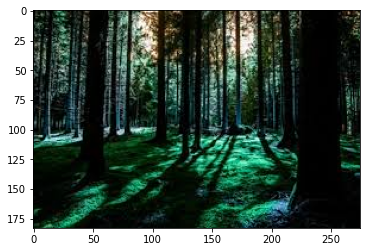

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
img=cv.imread(img)
#Displaying image using plt.imshow() method
plt.imshow(img)

AttributeError: ignored

In [ ]:
print("Evaluate on test data")
results = model.evaluate(pred_ds,batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data


InvalidArgumentError: ignored

In [ ]:
len(images)

1931

In [ ]:
y_test = []
images_array = []
i = 0
for image in images[:]:
  image = cv.imread(image)
  image = cv.resize(image,(150,150))
  image = image[:]/255.0
  print(i)
  i += 1
  images_array.append(image)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
images_final_array = np.array(images_array)
images_final_array.shape

(1931, 150, 150, 3)

In [ ]:
print(model.evaluate_generator(pred_ds))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


InvalidArgumentError: ignored

In [ ]:
y_test = model.predict(images_final_array)

61/61 [==============================] - 5s 89ms/step


In [ ]:
y_test.shape

(1931, 6)

In [ ]:
y_test_final = np.argmax(y_test,axis=1)

3
3
3
5
3
3
3
3
3
3
3
5
3
3
3
5
0
5
3
3
3
2
1
3
3
3
3
0
3
3
3
3
3
5
5
5
0
5
5
3
3
3
3
5
5
3
3
3
5
3
3
3
3
3
3
5
3
3
3
3
3
3
3
5
3
5
3
3
3
3
5
3
3
3
3
3
3
5
3
0
5
3
3
3
3
5
5
3
3
3
3
3
5
3
5
3
3
3
3
3
0
3
0
3
5
3
3
0
5
3
3
5
3
0
3
3
5
3
3
5
3
5
3
5
3
0
5
3
5
3
3
0
3
3
1
3
3
3
0
3
5
5
3
3
5
3
3
3
0
5
5
3
3
3
3
5
5
0
5
5
3
3
3
3
5
3
3
5
3
5
3
3
3
3
3
4
3
3
3
3
3
3
5
3
3
3
4
3
3
3
3
0
3
3
5
3
3
3
0
5
5
0
3
3
5
3
3
3
4
3
1
0
3
3
3
3
0
3
2
3
3
3
3
3
3
3
3
3
3
5
5
3
5
5
3
3
3
5
3
3
3
5
5
3
0
5
3
0
5
3
3
0
3
3
5
3
5
3
3
3
3
3
3
5
3
3
5
0
3
3
5
0
3
1
0
3
0
3
5
0
3
2
3
5
3
5
3
3
3
3
5
3
3
3
3
5
5
0
3
0
5
3
3
3
0
3
5
4
0
3
5
5
0
3
3
0
3
3
5
3
3
3
3
3
4
3
1
3
3
3
3
3
3
3
3
5
3
0
3
3
5
5
3
3
3
3
5
3
5
3
3
3
0
3
3
3
3
0
3
2
3
3
3
3
3
3
1
3
5
5
3
3
5
3
3
5
5
0
5
0
3
5
3
3
5
5
5
5
5
5
5
3
3
3
3
3
3
3
5
3
3
3
0
3
3
3
3
3
2
3
3
3
3
3
5
3
3
3
3
3
3
0
3
3
3
3
3
3
3
3
3
5
3
0
5
3
3
3
3
3
0
3
3
5
3
3
5
0
0
0
5
3
3
5
4
3
3
3
3
3
3
3
5
5
5
3
4
3
0
5
5
3
5
5
0
5
0
5
3
0
3
5
3
5
3
5
0
5
3
3
5
3
3
3
0
0
5
0
3
5


In [ ]:
len(images)

1931

In [ ]:
images[10]

'/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred/glaciers/220613-NASA-newly-identified-Polar-Bear-population-se-134p-67898c.jpg'

In [ ]:
print(glob.glob('/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred/*'))

['/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred/glaciers', '/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred/buildings', '/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred/forest', '/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred/mountains', '/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred/sea', '/content/drive/MyDrive/Datasets/2_intel/images/intel/inf_pred/street']


In [ ]:
y_test_original = []
for image in images[:]:
  text = image.split('/')[-2]
  if text == 'buildings':
    y_test_original.append(0)
  elif text == 'forest':
    y_test_original.append(1)
  elif text == 'glaciers':
    y_test_original.append(2)
  elif text == 'mountains':
    y_test_original.append(3)
  elif text == 'sea':
    y_test_original.append(4)
  elif text == 'street':
    y_test_original.append(5)


In [ ]:
len(y_test_original)

1931

In [ ]:
y_test_ori_array = np.array(y_test_original).shape

In [ ]:
print("Evaluate on test data")
results = model.evaluate(np.array(images_final_array),np.array(y_test_original))
print("test loss, test acc:", results)

Evaluate on test data


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


61/61 [==============================] - 5s 77ms/step - loss: 4.4001 - accuracy: 0.6328
test loss, test acc: [4.4001145362854, 0.6328327059745789]


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
type(y_test)

numpy.ndarray

In [ ]:
y_test.shape

(10000,)

In [ ]:
n_model = keras.models.load_model('/content/drive/MyDrive/Datasets/2_intel/best_trained_models/niharika_correct2_n2l.h5')

In [ ]:
n_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 331, 331, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 1000)              23851784  
                                                                 
 dense_3 (Dense)             (None, 6)                 6006      
                                                                 
Total params: 23,857,790
Trainable params: 6,006
Non-trainable params: 23,851,784
_________________________________________________________________


In [ ]:
import glob

In [ ]:
len(glob.glob('/content/drive/MyDrive/Datasets/2_intel/images/intel/seg_test/*/*'))

14034